# name: Marco Giunta
## Rlab06

In [1]:
library(tidyverse)
library(plotly)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout




# Exercise 1: radioactive source inference
Decay due to a radioactive source can be modelled as a Poisson process; this means that in a given time interval the number of emitted particles is $n \sim \text{Pois}(\mu)$ - where $\mu$ is the unknown parameter we wish to infer from the data.            
To apply Bayes' theorem as always we only need to specify the likelihood and the prior; as we already said the likelihood is given by the Poisson dist., whose conj. prior is the Gamma distribution. This can be rewritten formally as follows:
\begin{equation}
  \text{likelihood} = \text{Pois}(x|\mu) \propto \mu^x e^{-\mu}
\end{equation}
\begin{equation}
  \text{prior} = \text{Gamma}(x|\alpha,\lambda) \propto x^{\alpha-1}e^{-\lambda x}
\end{equation}
where $x$ (the number of observed events per unit time) is fixed by the data in our case, and where we omitted constant factors because they'll be absorbed in the overall normalization factor (the "evidence" denominator in Bayes' theorem).              
Choosing a gamma prior is useful because then the posterior will be a gamma dist. too, whose parameters are easily calculated by linearly combining the prior's parameters with the outcome of the experiment as follows:
\begin{equation}
  \text{single observation: } \text{posterior} = \text{Gamma}(\alpha', \lambda') \quad \text{where} \ \alpha' = \alpha + x, \ \lambda' = \lambda + 1
\end{equation}
\begin{equation}
  \text{$N$ observations: } \text{posterior} = \text{Gamma}(\alpha', \lambda') \quad \text{where} \ \alpha' = \alpha + \sum_{i = 1}^N x_i, \ \lambda' = \lambda + N
\end{equation}
(cfr stat07 pdf)               
Also notice that $\text{unif} = \text{Gamma}(1,0)$ and $\text{Jeffrey} = \text{Gamma}(1/2,0)$.         

## Ex. 1.1 & 1.2
The posterior's $\alpha$ and $\lambda$ parameters can be computed using the above formulae, which makes plotting the posterior trivial; the mean, mode and variance can be computed as follows.     
*Exact computation of the exp. value:* it can be shown that the exp. value of a gamma distribution is given by:
\begin{equation}
  \mathbb{E}[\text{posterior}] = \mathbb{E}[\text{Gamma}(\mu|x)] = \frac{\alpha'}{\lambda'}
\end{equation}
*Numerical estimation of the exp. value:* we can simply integrate numerically the integral in the definition of exp. value:
\begin{equation}
  \mathbb{E}[f(x)] = \int_I xf(x) \mathrm{d} x
\end{equation}
where in our case $I = \mathbb{R}^+$.

*Exact computation of the var.:* it can be shown that the var. of a gamma distribution is given by:
\begin{equation}
  \text{Var}[\text{posterior}] = \text{Var}[\text{Gamma}(\mu|x)] = \frac{\alpha'}{\lambda'^2} = \frac{\mathbb{E}[\dots]}{\lambda'}
\end{equation}
*Numerical estimation of the var.:* we can simply integrate numerically the integral in the definition of var.:
\begin{equation}
  \text{Var}[f(x)] = \int_I x^2 f(x) \mathrm{d} x - \mathbb{E}[f(x)]^2
\end{equation}
where in our case $I = \mathbb{R}^+$.

*Exact computation of mode:* it can be shown that the mode of a gamma distribution is given by:
\begin{equation}
  \text{mode} = \frac{\alpha-1}{\lambda}
\end{equation}
(the exercise test said to compute the median, but I assumed it was a typo because a) the mode is more interesting, and b) no analytical formula for the median exists).                
*Numerical estimation of the mode:* it suffices to find the max. of the posterior evaluated over a discrete grid of values.

[1] "Prior = Gamma(1.000000, 0.000000)"
[1] "Posterior: Gamma(13.000000, 5.000000)"
[1] "Exact and num. exp. val.: 2.600000, 2.600000"
[1] "Exact and num. var.: 0.520000, 0.520000"
[1] "Exact and num. mode: 2.400000, 2.408027"

[1] "Prior = Gamma(0.500000, 0.000000)"
[1] "Posterior: Gamma(12.500000, 5.000000)"
[1] "Exact and num. exp. val.: 2.500000, 2.500000"
[1] "Exact and num. var.: 0.500000, 0.500000"
[1] "Exact and num. mode: 2.300000, 2.307692"


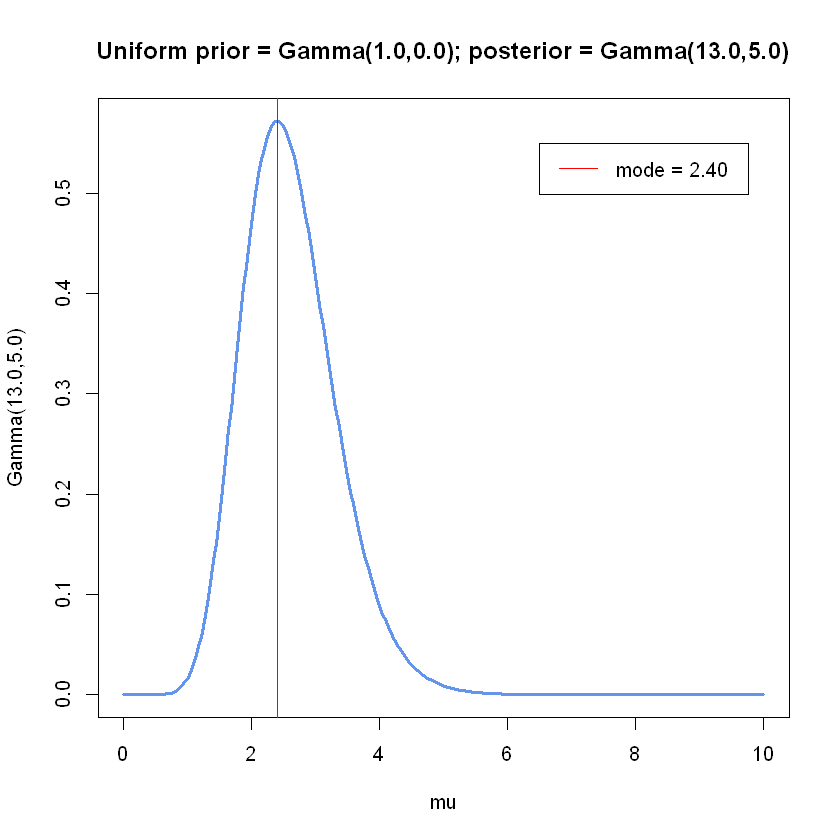

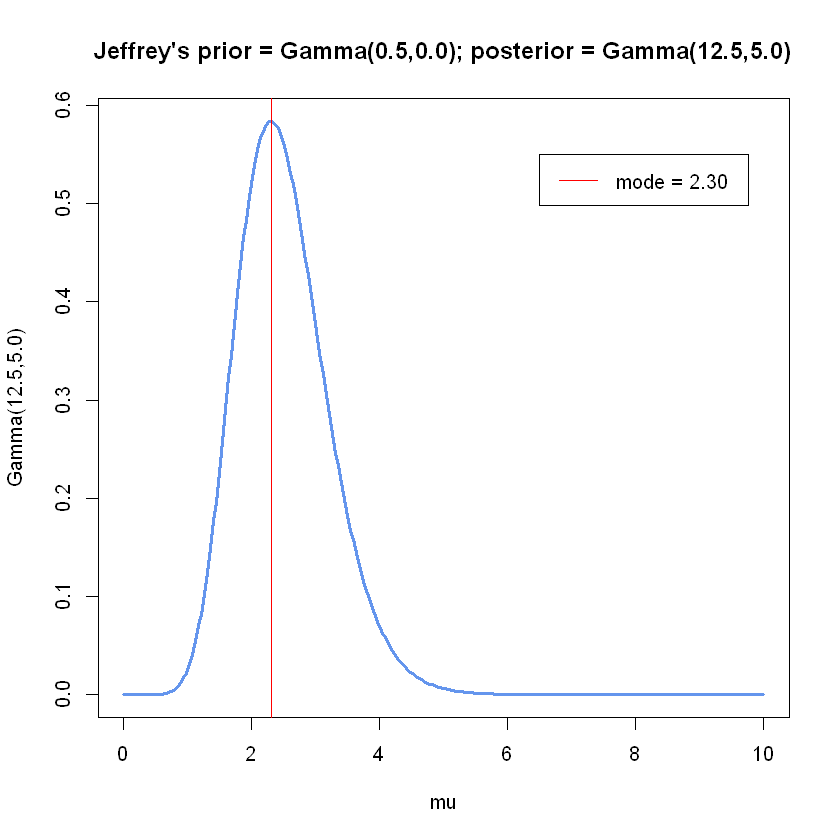

In [65]:
# data
x <- c(4,1,3,1,3)
# x-axis vector to plot the posteriors. 
mu.vector <- seq(0, 10, length.out = 300) # Notice that even though technically mu is in [0,+Inf] (in a Pois dist any mu>0 is allowed) the gamma dist. quickly decays to zero, so having mu in [0,10] is fine (as we will see).

# now we define a bunch of helper functions (technically unnecessary, but I appreciate clarity)
exp.exact  <- function(alpha, lambda) alpha/lambda
exp.num    <- function(alpha, lambda) integrate(function(x) x*dgamma(x, shape = alpha, rate = lambda), 0, Inf)$value
var.exact  <- function(alpha, lambda) alpha/lambda^2
var.num    <- function(alpha, lambda) (integrate(function(x) x^2*dgamma(x, shape = alpha, rate = lambda), 0, Inf)$value - exp.num(alpha, lambda)^2)                                         
mode.exact <- function(alpha, lambda) (alpha-1)/lambda
mode.num   <- function(alpha, lambda, x.vec) {
    posterior <- function(x) dgamma(x, shape = alpha, rate = lambda)
    return (x.vec[which.max(posterior(x.vec))]) 
}                            

# function to compute posterior function
compute.posterior <- function(alpha, beta) function(mu) dgamma(mu, shape = alpha, rate = lambda)                                                  
                                                 
# function to compute posterior's alpha & beta
compute.posterior.alpha.lambda <- function(ap, lp, data = x) {
    alpha <- ap + sum(data); lambda <- lp + length(data)
    return (c(alpha, lambda))
}                                                 

# function to compute the mode exactly (useful to plot a v. line)   
compute.mode <- function(alpha, lambda) (alpha-1)/lambda                                              
                                                 
# function to compute & print posterior parameters
print.posterior.parameters <- function(ap, lp, alpha, lambda, x.vec = mu.vector) {
    ee <- exp.exact(alpha, lambda); en <- exp.num(alpha, lambda); ve <- var.exact(alpha, lambda); vn <- var.num(alpha, lambda); me <- mode.exact(alpha, lambda); mn <- mode.num(alpha, lambda, x.vec)
    print(sprintf("Prior = Gamma(%f, %f)", ap, lp)); print(sprintf("Posterior: Gamma(%f, %f)", alpha, lambda))
    print(sprintf("Exact and num. exp. val.: %f, %f", ee, en)); print(sprintf("Exact and num. var.: %f, %f", ve, vn)); print(sprintf("Exact and num. mode: %f, %f", me, mn))
}
                                                 
# function to plot posterior
plot.gamma.posterior <- function(ap, lp, data = x, x.plot = mu.vector, prior.name, print.parameters = TRUE, plot.mode = TRUE) {
    # parameters computation
    tmp <- compute.posterior.alpha.lambda(ap, lp, data); alpha <- tmp[1]; lambda <- tmp[2]
    # printing parameters
    if (print.parameters) print.posterior.parameters(ap, lp, alpha, lambda, x.plot)
    # actual plot
    posterior <- compute.posterior(alpha, beta)
    plot(x.plot, posterior(x.plot), type = "l", main = sprintf("%s prior = Gamma(%.1f,%.1f); posterior = Gamma(%.1f,%.1f)", prior.name, ap, lp, alpha, lambda), lwd = 3, col = "cornflowerblue", xlab = "mu", ylab = sprintf("Gamma(%.1f,%.1f)", alpha, lambda))
    # adding mode (exact result) to the plot
    if (plot.mode) {
        mode <- compute.mode(alpha, lambda); abline(v = mode, col = "red"); legend(legend = sprintf("mode = %.2f", mode), col = "red", lty = 1, x = 6.5, y = 0.55)
    }
}

# uniform prior = gamma prior with alpha = 1, lambda = 0 --> posterior = gamma with alpha = 1+sum(x), lambda = length(x)
plot.gamma.posterior(1, 0, prior.name = "Uniform"); cat("\n")
# Jeffrey's prior = gamma prior with alpha = 1/2, lambda = 0 --> posterior = gamma with alpha = 0.5+sum(x), lambda = length(x)
plot.gamma.posterior(1/2, 0, prior.name = "Jeffrey's")

The two posteriors are very close; they have the same $\lambda$, and their $\alpha$'s only differ by 0.5. Why is this the case if the two priors are quite different (cfr next cell)?

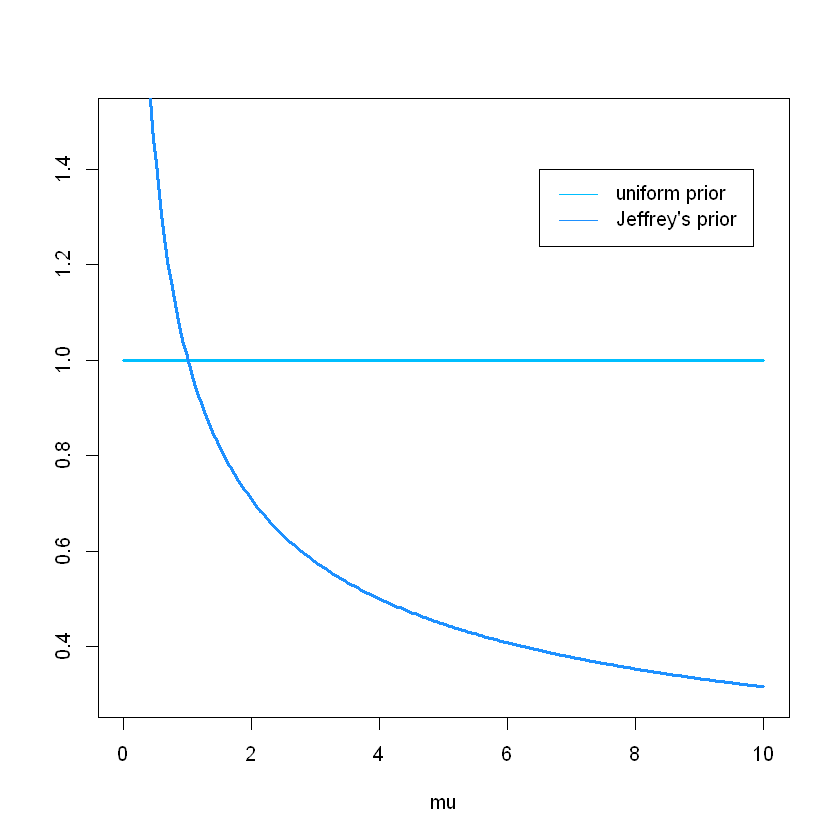

In [115]:
plot(mu.vector, rep(1, times = length(mu.vector)), type = "l", ylim = c(0.3, 1.5), xlab = "mu", ylab = "", lwd = 3, col = "deepskyblue")
lines(mu.vector, 1/sqrt(mu.vector), lwd = 3, col = "dodgerblue")
legend(legend = c("uniform prior", "Jeffrey's prior"), col = c("deepskyblue", "dodgerblue"), lty = rep(1, times = 2), x= 6.5, y = 1.4)

If different priors lead to similar posterior it's because *the likelihood dominates*; evidently the data we have for the Poisson likelihood is quite convincing.

## Ex. 1.3

In order to compute a $95\%$ credibility interval we need to find 2 values $x_1$ and $x_2$ such that $\int_{x_1}^{x_2} \text{posterior} = 0.95$; there are multiple ways to do this.     
1) we can find $x_1$ and $x_2$ by inspecting the posterior plot;
2) we can approximate the posterior with a gaussian with the same mean and variance and then exploit the fact that $\int_{\mu-2\sigma}^{\mu+2\sigma}\text{Gauss}(x|\mu,\sigma) = 0.95$.

Let's compare the two options.

[1] "Prior = Jeffrey's prior"
[1] "User-input values --> x1 = 1.130000, x2 = 3.860000"
[1] "posterior integral between these extrema: 0.950975359863949"
[1] "Gaussian approximation --> x1 = 1.085786, x2 = 3.914214"
[1] "posterior integral between these extrema: 0.957963339154411"


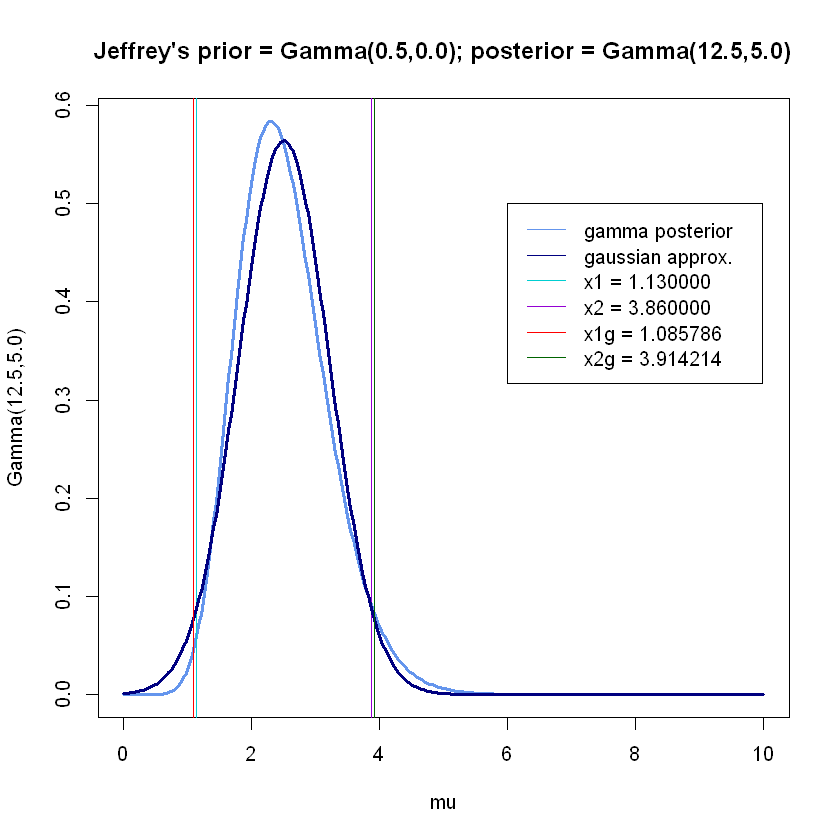

[1] "Prior = uniform prior"
[1] "User-input values --> x1 = 1.100000, x2 = 3.950000"
[1] "posterior integral between these extrema: 0.951904479447235"
[1] "Gaussian approximation --> x1 = 1.157779, x2 = 4.042221"
[1] "posterior integral between these extrema: 0.957866331505949"


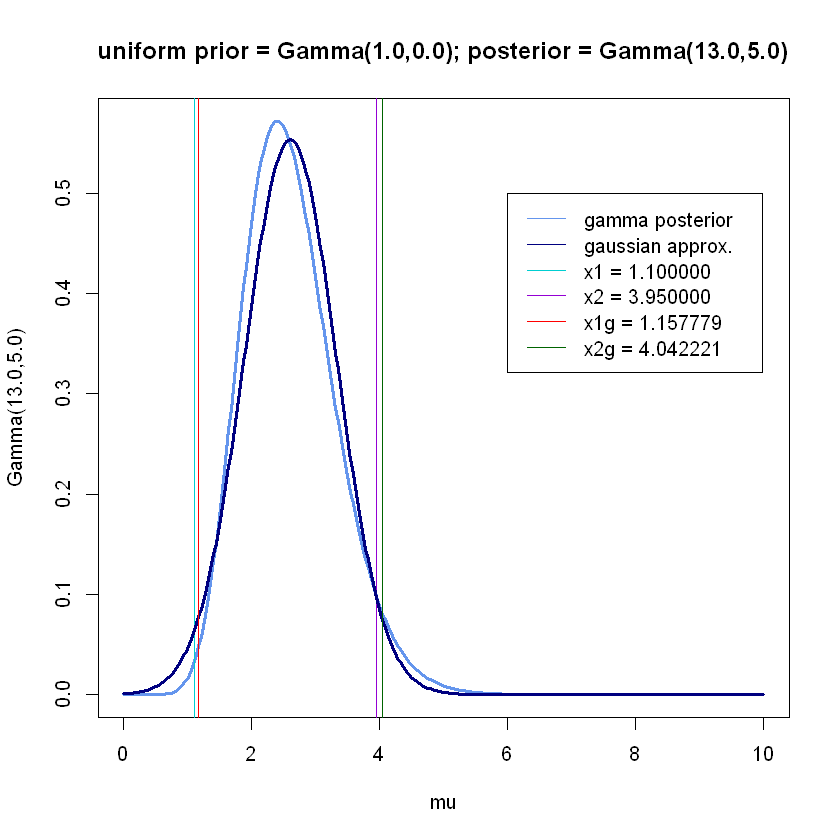

In [114]:
# Gamma mean and sd using exact formulae
compute.mean <- function(alpha, lambda) alpha/lambda
compute.sd   <- function(alpha, lambda) sqrt(alpha/lambda^2)

plot.print.gaussian.approx <- function(ap, lp, prior.name, x1, x2) {
    # posterior plot
    plot.gamma.posterior(ap, lp, prior.name = prior.name, print.parameters = FALSE, plot.mode = FALSE)
    abline(v = x1, col = "darkturquoise"); abline(v = x2, col = "darkviolet")
    # mean and sd computation
    tmp <- compute.posterior.alpha.lambda(ap = ap, lp = lp, data = c(4,1,3,1,3)); alpha <- tmp[1]; lambda <- tmp[2]
    m <- compute.mean(alpha, lambda)
    s <- compute.sd(alpha, lambda)
    # x1, x2 computation
    x1g <- m-2*s; x2g <- m+2*s # "g" stands for gaussian
    # gaussian plot
    lines(mu.vector, dnorm(mu.vector, mean = m, sd = s), lwd = 2.5, col = "navyblue", ylab = "")
    abline(v = x1g, col = "red"); abline(v = x2g, col = "darkgreen")
    legend(legend = c("gamma posterior", "gaussian approx.", sprintf("x1 = %f", x1), sprintf("x2 = %f", x2), sprintf("x1g = %f", x1g), sprintf("x2g = %f", x2g)), col = c("cornflowerblue", "navyblue", "darkturquoise", "darkviolet", "red", "darkgreen"), lty = rep(1, times = 6), x = 6, y = 0.5)
    
    print(sprintf("Prior = %s prior", prior.name))
    print(sprintf("User-input values --> x1 = %f, x2 = %f", x1, x2))
    print(paste("posterior integral between these extrema:", integrate(function(x) dgamma(x, shape = alpha, rate = lambda), x1, x2)$value))
    print(sprintf("Gaussian approximation --> x1 = %f, x2 = %f", x1g, x2g))
    print(paste("posterior integral between these extrema:", integrate(function(x) dgamma(x, shape = alpha, rate = lambda), x1g, x2g)$value))
}
     
# Jeffrey's prior --> ap = 1/2, lp = 0                                                                       
plot.print.gaussian.approx(ap = 0.5, lp = 0, prior.name = "Jeffrey's", x1 = 1.13, x2 = 3.86)        
# uniform prior --> ap = 1, lp = 0                                                                       
plot.print.gaussian.approx(ap = 1, lp = 0, "uniform", x1 = 1.1, x2 = 3.95)                                                                               

We notice that the gaussian approximation is so good there's actually no need to estimate $x_1$ and $x_2$ by hand as we did; we could simply use the values given to us by the gaussian approximation.        
Looking at the plot it's pretty clear why these estimate is so good: the gamma and the normal distributions are very close almost everywhere (especially if we use Jeffrey's prior), and where they aren't they compensate (e.g. the gaussian is too tall on the left but too short on the right, etc.).

# Exercise 2: lighthouse inference
## Some derivations
### *Likelihood (1 obs.)* 
We already showed that the likelihood function for a single observation $x_k$ in the lighthouse problem can be written as a *Cauchy distribution*:
\begin{equation}
  P(x_k|\alpha, \beta) = \frac{1}{\pi}\frac{\beta}{\beta^2 + (x_k - \alpha)^2} \propto \frac{\beta}{\beta^2 + (x_k - \alpha)^2}
\end{equation}
(where as always multiplicative constants are irrelevant because they'll be absorbed in the prior normalization factor).                 
If we need to infer both $\alpha$ and $\beta$ then our prior and posteriors will both need to be scalar functions with the 2D vector input $(\alpha, \beta)$.  
### *Likelihood ($N$ obs.)* 
If we have multiple independent observations we can use the product rule to obtain the likelihood:
\begin{equation}
  P(\{x_k\}_{k=1}^N|\alpha,\beta) = \prod_{k=1}^N P(x_k|\alpha,\beta) \propto \prod_{k=1}^N \frac{\beta}{\beta^2 + (x_k - \alpha)^2}
\end{equation}
This is a slightly more complicated function, but it still maps $(\alpha, \beta)$ to a scalar real value.        
### *log likelihood ($N$ obs.)*
If we want to we can use the log likelihood and then exponentiate at the end; this a) turns the product into a sum, and b) decreases the differences in the orders of magnitude of the interested values (which may avoid numerical conditioning). 
\begin{equation}
  \ln P(\{x_k\}_{k=1}^N|\alpha,\beta) = \ln \left(\prod_{k=1}^N P(x_k|\alpha,\beta)\right) = \sum_{k=1}^N \ln P(x_k|\alpha,\beta) \propto \sum_{k=1}^N \ln \frac{\beta}{\beta^2 + (x_k - \alpha)^2}
\end{equation}
This is good practice in many situations, but as it turns out in this case it's completely optional.
### *Prior* 
It's reasonable to use a uniform prior since we know nothing about the problem before seeing the data:
\begin{equation}
  P(\alpha,\beta) \propto 1
\end{equation}
If $\alpha$ and $\beta$ are in finite intervals then it's easy to show that the missing factor in the above prior is the normalization factor $1/[(\alpha_{\text{max}} - \alpha_{\text{min}})(\beta_{\text{max}} - \beta_{\text{min}})]$ - but there's actually no need to bother computing it, since it will be absorbed in the posterior's overall normalization factor.      
Still: if we want to be precise the prior we're using is:
\begin{equation}
  P(\alpha,\beta)=
  \left\{
  \begin{array}
    \ \dfrac{1}{(\alpha_{\text{max}} - \alpha_{\text{min}})(\beta_{\text{max}} - \beta_{\text{min}})} \ \ \text{if} \ \alpha \in [\alpha_{\text{min}},\alpha_{\text{max}}], \ \beta \in [\beta_{\text{min}}, \beta_{\text{max}}] \\
    \ \qquad \qquad 0 \qquad \qquad \quad \ \ \text{otherwise} \\
  \end{array}
  \right.
\end{equation}
### *Posterior (single obs.)* 
Bayes' theorem for a single observation $x_k$ in this case reads:
\begin{equation}
  P(\alpha,\beta|x_k) = \frac{P(x_k|\alpha,\beta)P(\alpha,\beta)}{P(x_k)} = \frac{P(x_k|\alpha,\beta)P(\alpha,\beta)}{\iint_D P(x_k|\alpha,\beta)P(\alpha,\beta) \ \mathrm{d}\alpha \ \mathrm{d}\beta}
\end{equation}
### *Posterior ($N$ obs.)*
In the case of $N$ independent observations $\{x_k\}_{k=1}^N$ the posterior becomes (prod. rule):
\begin{equation}
  P(\alpha,\beta|\{x_k\}_{k=1}^N) = \frac{P(\{x_k\}_{k=1}^N|\alpha,\beta)P(\alpha,\beta)}{P(\{x_k\}_{k=1}^N)} = \frac{\prod_{k=1}^N P(x_k|\alpha,\beta)P(\alpha,\beta)}{\iint_D \prod_{k=1}^N P(x_k|\alpha,\beta)P(\alpha,\beta) \ \mathrm{d}\alpha \ \mathrm{d}\beta}
\end{equation}
Since the prior is uniform this means that 
\begin{equation}
  \text{posterior}\propto\text{likelihood for $N$ observations}
\end{equation}
and - as we show in the next subsection - this is the only result we actually need to infer the values of $\alpha$ and $\beta$.

### *Evidence & marginalization*
In order to properly normalize the posterior we need to compute the integral:
\begin{equation}
  \int_{\alpha_1}^{\alpha_2} \int_{\beta_1}^{\beta_2}  \frac{\beta}{\beta^2 + (x_k-\alpha)^2} \ \mathrm{d}\alpha \ \mathrm{d}\beta
\end{equation}
which (due to independence between the product over $k$ and the integral over $alpha, beta$) becomes
\begin{equation}
  \int_{\alpha_1}^{\alpha_2} \int_{\beta_1}^{\beta_2} \prod_{k=1}^N \dots = \prod_{k=1}^N \int_{\alpha_1}^{\alpha_2} \int_{\beta_1}^{\beta_2} \dots
\end{equation}
in the case of $N$ observations.               
A simple strategy to compute this integral is to first integrate exactly wrt to one of the variables, then to integrate numerically (using e.g. `base::integrate`) the resulting 1D integral.       
It's easy to show that
\begin{equation}
  \int_{\alpha_1}^{\alpha_2} \frac{\beta}{\beta^2 + (x_k-\alpha)^2} \ \mathrm{d}\alpha = \arctan\left(\frac{x_k-\alpha_1}{\beta} \right) - \arctan\left(\frac{x_k-\alpha_2}{\beta} \right) = \ \text{fun. of $\beta$}
\end{equation}
and that
\begin{equation}
  \int_{\beta_1}^{\beta_2} \frac{\beta}{\beta^2 + (x_k-\alpha)^2} \ \mathrm{d}\beta = \ln\sqrt{\frac{\beta_2^2+(x_k-\alpha)^2}{\beta_1^2+(x_k-\alpha)^2}} = \ \text{fun. of $\alpha$}
\end{equation}
Either of these can easily be evaluated numerically.          
Notice that *as long as we only care about parameter estimation normalizing the posterior is optional*; if we only want to know where the max. is there's no need to worry about a factor which merely scales the vertical axis (this of course no longer holds if we want, say, to estimate credibility intervals, because in that case we need an actual, normalized pdf).              
This doesn't mean the above results are useless, though! Indeed as an alternative to doing a 3D surface plot of the whole 2D argument posterior (which we can still do) we can use these integrals to *marginalize* the posterior, which makes it easier to plot and estimate the parameters (since one of them disappears, as if it was a nuisance parameter).

## Data generation & 3D plotting
The problem gives us no data, which means we need to simulate some $x_k$ samples. This is easy; we can either sample $\theta_k$ from $U[-\pi/2,\pi/2]$ and then use $x_k = \alpha + \beta \tan \theta_k$ or we can sample $x_k$ directly from the Cauchy disttribution. This of course forces us to choose "true" values for $\alpha$ and $\beta$; we can set both of them equal to 1 km, for example.            
Now that we fixed the data generation algorithm we only need to choose the min./max. values for $\alpha$ and $\beta$; even though in principle this is a delicate choice in practice there's not much to worry about - as we discuss as follows.                     
Notice that outside the $[\alpha_{\text{min}},\alpha_{\text{max}}]\times [\beta_{\text{min}}, \beta_{\text{max}}]$ set the posterior will be automatically zero due to the uniform prior; this can hinder the inference if the intervals we select aren't large enough to contain the true values, so in principle we would need very large intervals. What helps is that even with few data points the posterior is significantly nonzero in a narrow region and quickly drops to zero outside of it, so choosing $\alpha$ to be in e.g. $[-6,6]$ and $\beta$ in $[0,6]$ ($\beta$ cannot be negative) is actually enough, as we'll see.          
This region is the one we need to to a 3D surface plot of the non-marginalized posterior, which we can do as follows:
- we create a discretize meshgrid in $[\alpha_{\text{min}},\alpha_{\text{max}}]\times [\beta_{\text{min}}, \beta_{\text{max}}]$ using e.g. `pracma::meshgrid`;
- we evaluate the posterior over this grid using e.g. a nested double for loop;
- we finally plot the result using `plotly::plot_ly`.

One last thing: first we do a simple analysis where we plot the results of the inference using a single value of $N$; then we repeat everything comparing ascending values of $N$ = n. of observations.

In [8]:
# DATA GENERATION
set.seed(12345)
n.samples <- 100; alpha.true <- 1; beta.true <- 1
#x.data   <- beta.true*tan(runif(n = n.samples, min = -pi/2, max = pi/2)) + alpha.true # equivalent way to do this
x.data    <- rcauchy(n = n.samples, location = alpha.true, scale = beta.true)

# CAUCHY LIKELIHOOD
likelihood     <- function(alpha, beta) prod(beta/(beta^2+(x.data - alpha)^2)) # we could also use dcauchy; I prefer to be explicit, though
log.likelihood <- function(alpha, beta) sum(-1*log(1+((x.data-alpha)/beta)^2)) # we can also work with the log likelihood

# POSTERIOR 3D SURFACE PLOT (all data points)
grid.length <- 100; alpha.min <- -6; alpha.max <- 6; beta.min <- 0; beta.max <- 6
mesh <- pracma::meshgrid(x = seq(alpha.min, alpha.max, length.out = grid.length), y = seq(beta.min, beta.max, length.out = grid.length)) # mesh creation
X <- mesh$X; Y <- mesh$Y # alpha and beta mesh grids, actually (I'm lazy)

Z <- matrix(data = 0, nrow = grid.length, ncol = grid.length)
for (i in 1:grid.length) {
    for (j in 1:grid.length) {
        #Z[i,j] <- exp(log.likelihood(X[i,j], Y[i,j])) # if we use wish to use the log.likelihood
        Z[i,j] <- likelihood(X[i,j], Y[i,j])
    }
} # I've had some issues vectorizing the likelihood the way I wanted (i.e. to be able to feed it the 2 grid matrices), so I went the explicit way with a double loop. #
# This could probably be avoided with something like sapply or outer(seq(..), seq(..), FUN = likelihood), but I'm content with the lazy option

plot_ly(x = X, y = Y, z = Z) %>% add_surface(contours = list(z = list(show = TRUE, usecolormap = TRUE, highlightcolor="#ff0000", project = list(z = TRUE)))) %>% layout(
    title = "Unnormalized posterior",
    scene = list(
      xaxis = list(title = "alpha"),
      yaxis = list(title = "beta"),
      zaxis = list(title = "posterior")
    )) # weird code format, but it didn't fit the screen otherwise

# Notice the contour plot, visible on the roof and on the floor (here one needs to over the surface with the mouse pointer to show the contour lines)

print(sprintf("Inferred alpha: %f", X[which.max(Z)]))
print(sprintf("Inferred beta: %f", Y[which.max(Z)]))

HTML widgets cannot be represented in plain text (need html)

[1] "Inferred alpha: 0.909091"
[1] "Inferred beta: 0.909091"


As we can see our posterior is sharply peaked around the correct values!

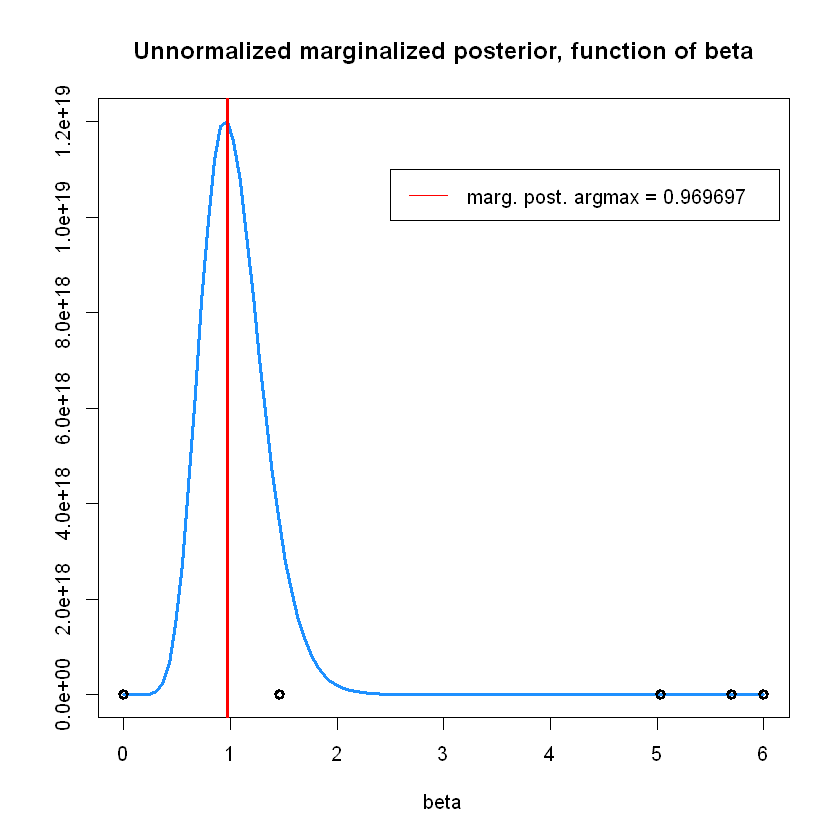

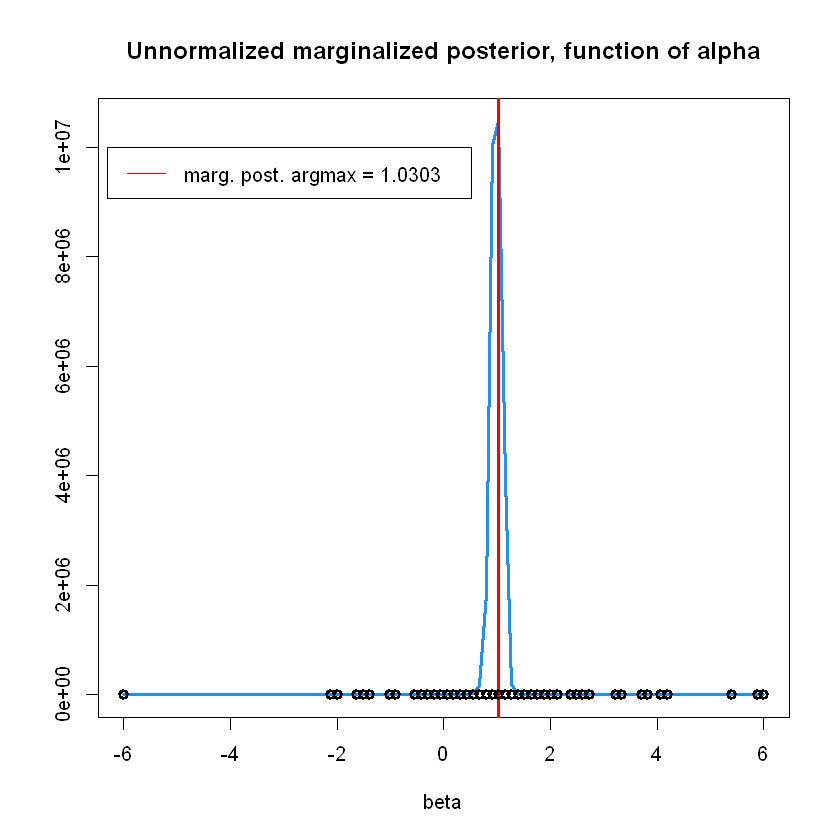

In [28]:
# MARGINALIZED POSTERIORS
marginalized.posterior.f.beta  <- Vectorize(function(beta)  prod(atan((x.data - alpha.min)/beta)-atan((x.data - alpha.max)/beta)))
marginalized.posterior.f.alpha <- Vectorize(function(alpha) prod(log(sqrt((beta.max^2+(x.data - alpha)^2)/(beta.min^2+(x.data - alpha)^2)))))
                                            
# SINGLE OBS. MARGINALIZED POSTERIOR
marginalized.posterior.f.alpha.single.obs <- function(x, alpha.vec) log(sqrt((beta.max^2+(x - alpha.vec)^2)/(beta.min^2+(x - alpha.vec)^2)))
most.likely.alpha.single.obs <- Vectorize(function(x) { # x is a single data point
    alpha.vec <- seq(alpha.min, alpha.max, length.out = grid.length)
    return (alpha.vec[which.max(marginalized.posterior.f.alpha.single.obs(x, alpha.vec))])
})
                                          
marginalized.posterior.f.beta.single.obs <- function(x, beta.vec) atan((x - alpha.min)/beta.vec) - atan((x - alpha.max)/beta.vec)
most.likely.beta.single.obs <-  Vectorize(function(x) { # x is a single data point
    beta.vec <- seq(beta.min, beta.max, length.out = grid.length)
    return (beta.vec[which.max(marginalized.posterior.f.beta.single.obs(x, beta.vec))])
}) # it may be interesting to visualize how the alphas/betas we can infer from each single data point scatter around the overall peak
# (this was done in the lecture notes, anyway)                                            
                                            
# MARGINALIZED POSTERIOR PLOTS (all data points)
beta.values <- seq(beta.min, beta.max, length.out = 100)
y.beta <- marginalized.posterior.f.beta(beta.values); inferred.beta.marg <- beta.values[which.max(y.beta)]                               
plot(beta.values, y.beta, type = "l", lwd = 3, col = "dodgerblue", main = "Unnormalized marginalized posterior, function of beta", xlab = "beta", ylab = "")
abline(v = inferred.beta.marg, col = "red", lwd = 2.5)       
legend(legend = sprintf("marg. post. argmax = %f", inferred.beta.marg), x = 2.5, y = 1.1e19, lty = 1, col = "red")             

points(most.likely.beta.single.obs(x.data), rep(0, times = length(x.data)), lwd = 3)                                            
                                            
alpha.values <- seq(alpha.min, alpha.max, length.out = 100)
y.alpha <- marginalized.posterior.f.alpha(alpha.values); inferred.alpha.marg <- alpha.values[which.max(y.alpha)]                                              
plot(alpha.values, y.alpha, type = "l", lwd = 3, col = "dodgerblue", main = "Unnormalized marginalized posterior, function of alpha", xlab = "beta", ylab = "") 
abline(v = inferred.alpha.marg, col = "red", lwd = 2.5) 
legend(legend = sprintf("marg. post. argmax = %.4f", inferred.alpha.marg), x = -6.3, y = 1e7, lty = 1, col = "red")       
  
points(most.likely.alpha.single.obs(x.data), rep(0, times = length(x.data)), lwd = 3)                                                 
                                            
#print(sprintf("Inferred alpha from marginalized posterior: %f", inferred.beta.marg)) # this information is already in the plots
#print(sprintf("Inferred beta from marginalized posterior: %f", inferred.alpha.marg))                                            

Even with the marginalized posteriors the result is pretty unambiguous.

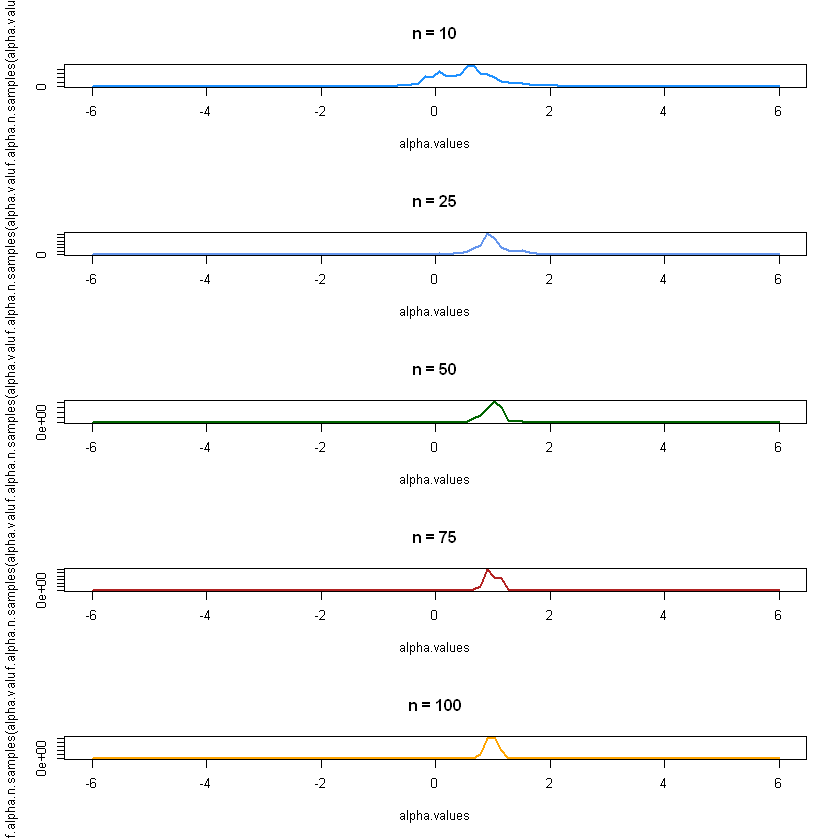

In [64]:
# now we show how the posterior evolves as we increase the size of the dataset. For simplicity we only show the marginalized distributions

par(mfrow = c(5,1)) # for some reason I'm struggling to produce a readable plot with jupyter
for (i in 1:5) plot(alpha.values, marginalized.posterior.f.alpha.n.samples(alpha.values, n = n.samples.vec[i]), type = "l", col = col.vec[i], lwd = 2, main = sprintf("n = %d", n.samples.vec[i]))
# since we're plotting each posterior separately we can be lazy and not normalize them

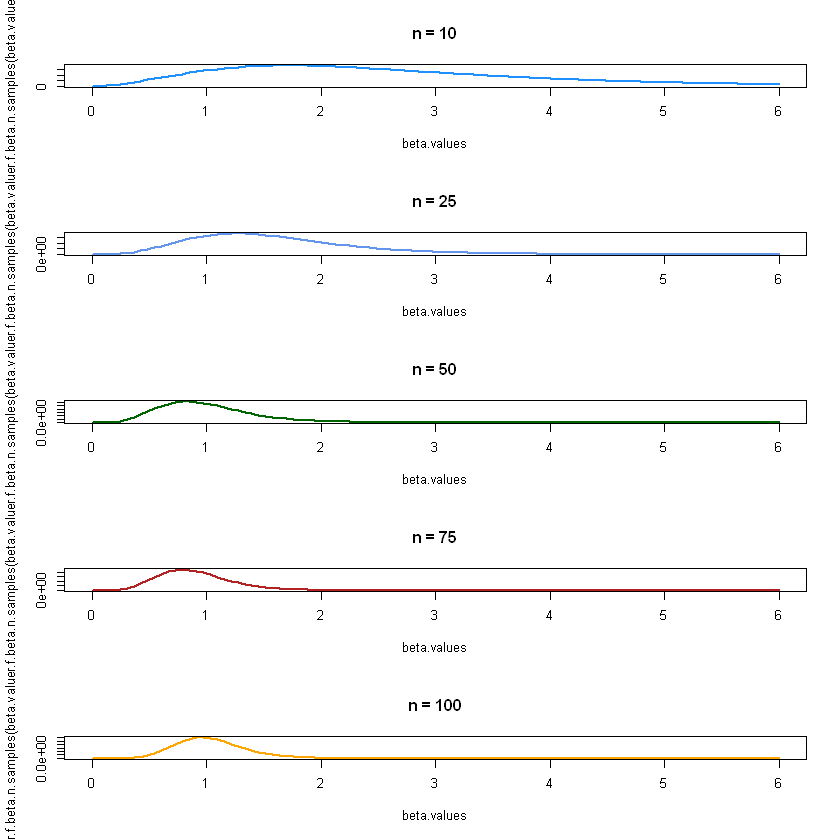

In [74]:
par(mfrow = c(5,1)) # for some reason I'm struggling to produce a readable plot with jupyter
for (i in 1:5) plot(beta.values, marginalized.posterior.f.beta.n.samples(beta.values, n = n.samples.vec[i]), type = "l", col = col.vec[i], lwd = 2, main = sprintf("n = %d", n.samples.vec[i]))

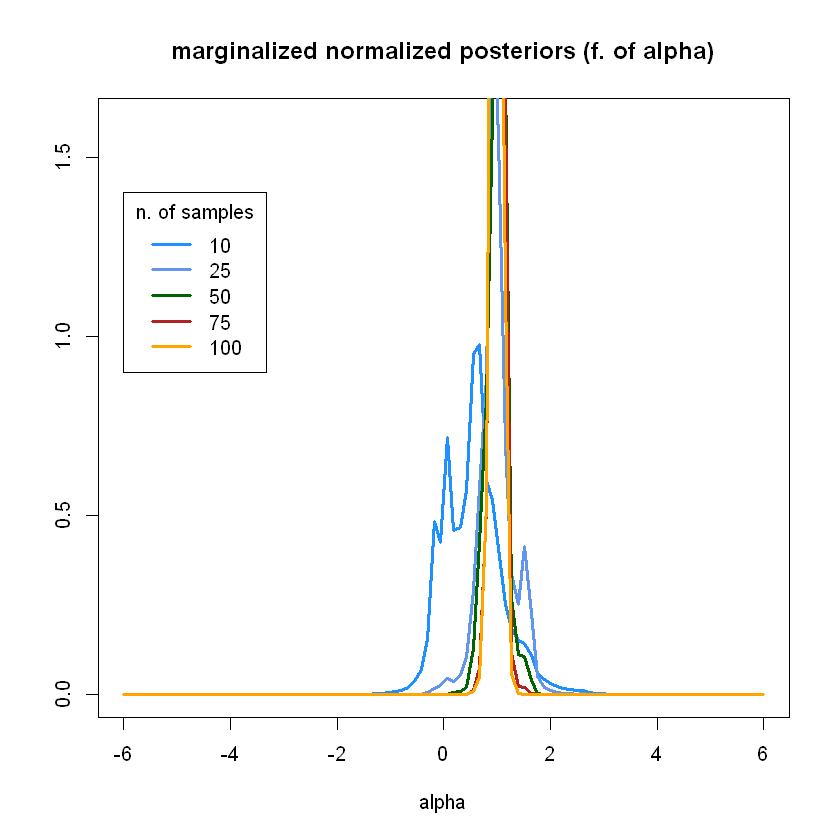

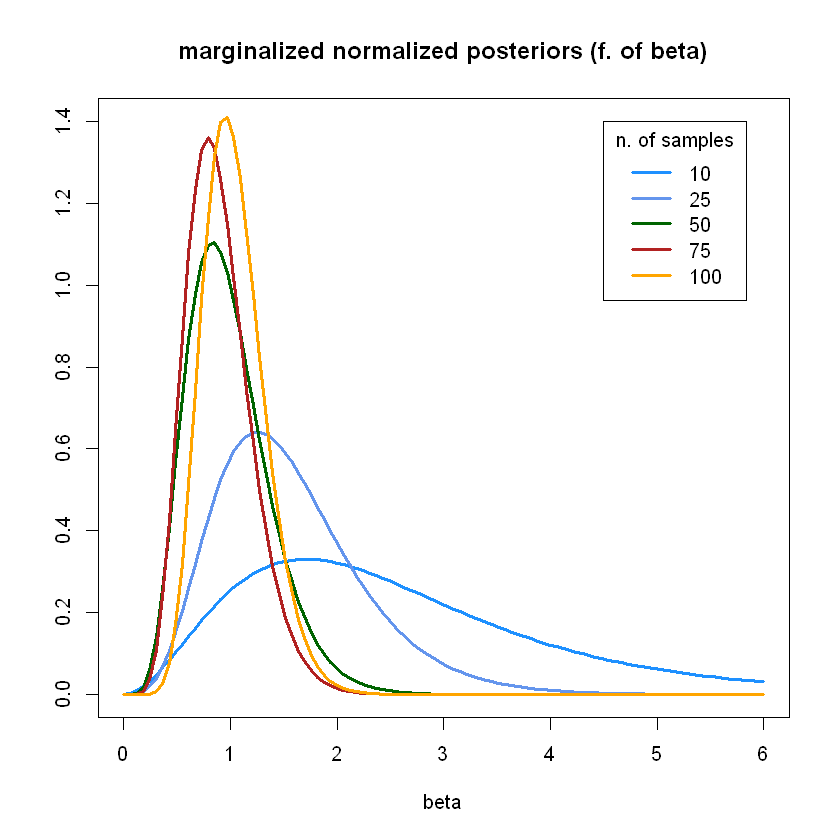

In [115]:
# now we show how the posterior evolves as we increase the size of the dataset. For simplicity we only show the marginalized distributions
# Notice that in order to have a comparison between posteriors we need to normalize them; otherwise they span too different scales

# MARGINALIZED POSTERIORS FOR PARTIAL DATASETS
marginalized.posterior.f.beta.n.samples  <- Vectorize(function(beta, n)  prod(atan((x.data[1:n] - alpha.min)/beta)-atan((x.data[1:n] - alpha.max)/beta)))
marginalized.posterior.f.alpha.n.samples <- Vectorize(function(alpha, n) prod(log(sqrt((beta.max^2+(x.data[1:n] - alpha)^2)/(beta.min^2+(x.data[1:n] - alpha)^2)))))
                                            
n.samples.vec <- c(10, 25, 50, 75, 100); col.vec <- c("dodgerblue", "cornflowerblue", "darkgreen", "firebrick", "orange")
                   
y.plot   <- marginalized.posterior.f.alpha.n.samples(alpha.values, n = n.samples.vec[1])   
integral <- integrate(marginalized.posterior.f.alpha.n.samples, lower = alpha.min, upper = alpha.max, n = n.samples.vec[1])$value                                                     
plot(alpha.values, y.plot/integral, type = "l", col = col.vec[1], lwd = 3, xlab = "alpha", ylab = "", main = "marginalized normalized posteriors (f. of alpha)", ylim = c(0, 1.6))
                                                      
for (i in 2:length(n.samples.vec)) {
    y.plot   <- marginalized.posterior.f.alpha.n.samples(alpha.values, n = n.samples.vec[i])   
    integral <- integrate(marginalized.posterior.f.alpha.n.samples, lower = alpha.min, upper = alpha.max, n = n.samples.vec[i], subdivisions = 200)$value   
    lines(alpha.values, y.plot/integral, col = col.vec[i], lwd = 3)
}
legend(legend = as.character(n.samples.vec), x = -6, y = 1.4, col = col.vec, lty = rep(1, times = length(n.samples.vec)), title = "n. of samples", lwd = 3)                                                     

y.plot   <- marginalized.posterior.f.beta.n.samples(beta.values, n = n.samples.vec[1])   
integral <- integrate(marginalized.posterior.f.beta.n.samples, lower = beta.min, upper = beta.max, n = n.samples.vec[1])$value                                                         
plot(beta.values, y.plot/integral, type = "l", col = col.vec[1], lwd = 3, xlab = "beta", ylab = "", main = "marginalized normalized posteriors (f. of beta)", ylim = c(0,1.4))
                                                      
for (i in 2:length(n.samples.vec)) {
    y.plot   <- marginalized.posterior.f.beta.n.samples(beta.values, n = n.samples.vec[i])   
    integral <- integrate(marginalized.posterior.f.beta.n.samples, lower = beta.min, upper = beta.max, n = n.samples.vec[i], subdivisions = 200)$value   
    lines(beta.values, y.plot/integral, col = col.vec[i], lwd = 3)
}
legend(legend = as.character(n.samples.vec), x = 4.5, y = 1.4, col = col.vec, lty = rep(1, times = length(n.samples.vec)), title = "n. of samples", lwd = 3)                                                           

Once again we notice that as the size of the dataset increases the posterior gets narrower and narrower, closing in on $\alpha = \alpha_{\text{true}} = 1$, $\beta = \beta_{\text{true}} = 1$.

# Exercise 3: signal vs noise inference